In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
# ============================ Imports ============================
import os
import pandas as pandas_lib
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as neural_network
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# ============================ Data Preprocessing ============================

# Load CSV files containing training labels and test image IDs
training_dataframe = pandas_lib.read_csv('/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv')
testing_dataframe = pandas_lib.read_csv('/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv')

# Add full image paths to the dataframes
training_dataframe['image_path'] = '/kaggle/input/soil-classification/soil_classification-2025/train/' + training_dataframe['image_id']
testing_dataframe['image_path'] = '/kaggle/input/soil-classification/soil_classification-2025/test/' + testing_dataframe['image_id']

# Map each unique soil type to an integer label
label_to_index_mapping = {label: index for index, label in enumerate(training_dataframe['soil_type'].unique())}
index_to_label_mapping = {index: label for label, index in label_to_index_mapping.items()}
training_dataframe['label_index'] = training_dataframe['soil_type'].map(label_to_index_mapping)

# Split training data into training and validation sets using stratified sampling
training_subset, validation_subset = train_test_split(
    training_dataframe,
    test_size=0.1,
    stratify=training_dataframe['label_index'],
    random_state=42
)

# ============================ Image Transformations ============================

image_transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ============================ Dataset Definition ============================

class SoilImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, is_testing=False):
        self.dataframe = dataframe
        self.transform = transform
        self.is_testing = is_testing

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe.iloc[index]['image_path']
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.is_testing:
            return image
        else:
            label = self.dataframe.iloc[index]['label_index']
            return image, label

# ============================ Data Loaders ============================

training_loader = DataLoader(SoilImageDataset(training_subset, image_transformation), batch_size=32, shuffle=True)
validation_loader = DataLoader(SoilImageDataset(validation_subset, image_transformation), batch_size=32)
testing_loader = DataLoader(SoilImageDataset(testing_dataframe, image_transformation, is_testing=True), batch_size=32)

# ============================ Model Setup ============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18()  
state_dict = torch.load("/kaggle/input/resnet18/resnet18-f37072fd.pth", map_location=device)
model.load_state_dict(state_dict)

model.fc = neural_network.Linear(model.fc.in_features, len(label_to_index_mapping))  # Output layer for 4 classes
model = model.to(device)

loss_function = neural_network.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ============================ Optional Training Augmentations ============================

training_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

# ============================ Model Training Function ============================

def train_model(number_of_epochs=5):
    best_validation_accuracy = 0.0

    for epoch_number in range(number_of_epochs):
        model.train()
        total_training_loss = 0.0
        correct_training_predictions = 0
        total_training_samples = 0

        for images, labels in training_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            total_training_loss += loss.item() * images.size(0)
            _, predicted_classes = torch.max(outputs, 1)
            correct_training_predictions += (predicted_classes == labels).sum().item()
            total_training_samples += labels.size(0)

        training_accuracy = correct_training_predictions / total_training_samples
        print(f"Epoch {epoch_number+1}, Loss: {total_training_loss/total_training_samples:.4f}, Accuracy: {training_accuracy:.4f}")

        # ============================ Model Validation ============================
        model.eval()
        correct_validation_predictions = 0
        total_validation_samples = 0

        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted_classes = torch.max(outputs, 1)
                correct_validation_predictions += (predicted_classes == labels).sum().item()
                total_validation_samples += labels.size(0)

        validation_accuracy = correct_validation_predictions / total_validation_samples
        print(f"Validation Accuracy: {validation_accuracy:.4f}")

        # Save the best model
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            torch.save(model.state_dict(), "best_soil_model.pth")
            print("✅ Saved new best model")

# Train the model
train_model(number_of_epochs=5)

# ============================ Inference on Test Set ============================

# Load the best model and switch to evaluation mode
model.load_state_dict(torch.load("best_soil_model.pth"))
model.eval()

predicted_indices = []
with torch.no_grad():
    for images in testing_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted_classes = torch.max(outputs, 1)
        predicted_indices.extend(predicted_classes.cpu().numpy())

# ============================ Submission File Generation ============================

# Map predicted indices to original soil type labels
testing_dataframe['predicted_label'] = [index_to_label_mapping[predicted_index] for predicted_index in predicted_indices]

# Format the submission DataFrame
submission_dataframe = testing_dataframe[['image_id', 'predicted_label']].rename(columns={'predicted_label': 'soil_type'})
submission_dataframe.to_csv("submission.csv", index=False)

print("✅ Submission file has been saved as 'submission.csv'")


Epoch 1, Loss: 0.4344, Accuracy: 0.8535
Validation Accuracy: 0.9431
✅ Saved new best model
Epoch 2, Loss: 0.1048, Accuracy: 0.9672
Validation Accuracy: 1.0000
✅ Saved new best model
Epoch 3, Loss: 0.0422, Accuracy: 0.9891
Validation Accuracy: 1.0000
Epoch 4, Loss: 0.0285, Accuracy: 0.9945
Validation Accuracy: 1.0000
Epoch 5, Loss: 0.0379, Accuracy: 0.9900
Validation Accuracy: 1.0000
✅ Submission file has been saved as 'submission.csv'


In [17]:
from torchvision import models
import torch.nn as neural_network

def evaluate_model():
    model = models.resnet18()
    model.fc = neural_network.Linear(model.fc.in_features, len(label_to_index_mapping))
    model.load_state_dict(torch.load("best_soil_model.pth"))
    model = model.to(device)
    model.eval()

    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted_classes = torch.max(outputs, 1)
            all_predictions.extend(predicted_classes.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_true_labels, all_predictions, target_names=list(label_to_index_mapping.keys()), output_dict=True)
    report_df = pandas_lib.DataFrame(report).transpose()
    print("🔍 Precision-Recall-F1 Report on Validation Set:\n")
    print(report_df[['precision', 'recall', 'f1-score']])

    # Confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index_mapping.keys(), yticklabels=label_to_index_mapping.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix on Validation Set')
    plt.tight_layout()
    plt.show()


🔍 Precision-Recall-F1 Report on Validation Set:

               precision  recall  f1-score
Alluvial soil        1.0     1.0       1.0
Clay soil            1.0     1.0       1.0
Red soil             1.0     1.0       1.0
Black Soil           1.0     1.0       1.0
accuracy             1.0     1.0       1.0
macro avg            1.0     1.0       1.0
weighted avg         1.0     1.0       1.0


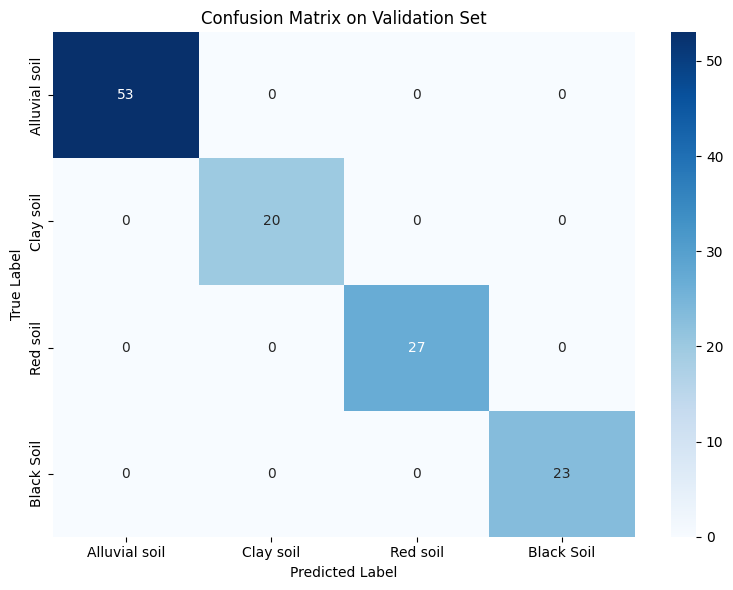

In [18]:
evaluate_model()